In [ ]:
!curl https://raw.githubusercontent.com/ggonzalesd/Deep-Learning-Project/main/brain_tumor_dataset.py --output brain_tumor_dataset.py

!wget https://raw.githubusercontent.com/ggonzalesd/Deep-Learning-Project/main/classification_models.py --output classification_models.py
!wget https://raw.githubusercontent.com/ggonzalesd/Deep-Learning-Project/main/trainer.py --output trainer.py

## Import modules

In [1]:
import h5py                                           # Read .Mat Files
import random                                         # Get random integers
import pandas as pd                                   # Read CSV
import numpy as np                                    # Transform and save arrays
from skimage.draw import polygon                      # Create images from points

import torch                                          # Framework
from torch import optim                               # optim: Adam, SDG
from torch import nn

from torch.utils import data                          # Data
from torchvision import transforms                    # Transform dataset images

import matplotlib.pyplot as plt                       # Visualize images and more

from brain_tumor_dataset import BrainTumorDataset     # Dataset
import classification_models as models                # Module for models
from trainer import Trainer, ModelCheckpoint          # Trainer Class

/home/poggers/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocessing Dataset | (from .mat to .npy)

Download and unzip dataset

In [12]:
!curl https://figshare.com/ndownloader/articles/1512427/versions/5 --output data.zip
!mkdir tmp_dataset
!mkdir dataset
!unzip data.zip -d ./tmp_dataset
!for file in ./tmp_dataset/*.zip; do unzip $file -d ./tmp_dataset/; done
!rm ./tmp_dataset/*.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0  838M    0 29769    0     0  17936      0 13:37:15  0:00:01 13:37:14 17943^C
mkdir: cannot create directory ‘dataset’: File exists
Archive:  data.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of data.zip or
        data.zip.zip, and cannot find data.zip.ZIP, period.
zsh:1: no matches found: ./tmp_dataset/*.zip
zsh:1: no matches found: ./tmp_dataset/*.zip


Convert .mat to .npy

In [ ]:
data_tmp = {'image':[], 'label':[]}
index = 0
for i in range(3064):
  with h5py.File(f"tmp_dataset/{i+1}.mat", 'r') as f:
    img = np.array(f.get('cjdata/image'), dtype=np.float32)
    if img.shape == (512, 512):
      border = np.array(f.get('cjdata/tumorBorder')).reshape((-1, 2))
      name = f"{index+1}.npy"
      img = img / img.max()

      mask = np.zeros_like(img, dtype=np.float32)
      rr, cc = polygon(border[:,0], border[:,1], img.shape)
      mask[rr,cc] = 1.0

      result = np.stack([img, mask], axis=2)

      np.save("./dataset/"+name, result)
      data_tmp['image'].append(name)
      data_tmp['label'].append(np.array(f.get('cjdata/label'), dtype=np.int64).item()-1)
      index += 1

Save labels in a CSV file

In [ ]:
df = pd.DataFrame(data_tmp)
df.to_csv('./dataset/data.csv', index=False)
df.head()
del df, data_tmp

Remove MAT files

In [ ]:
!rm -rf tmp_dataset

## Functions Tools

In [2]:
def split_dataset(dataset, train_size=0.8):
  n = len(dataset)
  n_train = int(n*train_size)
  n_val = n - n_train
  train_dataset, val_dataset = data.random_split(dataset, [n_train, n_val])
  return train_dataset, val_dataset

def plot_train_loss(model_dic, label=None, legend='upper center', model_name=None):
  """
     This method allows you to view the history of the loss function per epoch
  """
  train_loss_history = model_dic['train_loss_history']
  x_values = range(1, len(train_loss_history) + 1)
  plt.figure(figsize=(7, 5))
  if model_name is None:
    plt.title('Training loss')
  else:
    plt.title('Training loss using ' + model_name)

  if label is not None:
    plt.plot(x_values, train_loss_history, '-o', label=label)
    plt.legend(loc=legend)
  else:
    plt.plot(x_values, train_loss_history, '-o')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

def plot_accuracy(model_dic, model_name=None):
  """
     This method allows you to view the historical accuracy per epoch
  """  
  train_acc_history = model_dic['train_acc_history']
  val_acc_history = model_dic['val_acc_history']
  x_values = range(1, len(train_acc_history) + 1)
  plt.figure(figsize=(7, 5))
  if model_name is None:
    plt.title('Accuracy')
  else:
    plt.title('Accuracy using ' + model_name )
  plt.plot(x_values, train_acc_history, '-o', label='train')
  plt.plot(x_values, val_acc_history, '-o', label='val')
  plt.ylabel('Accuracy')  
  plt.xlabel('Epoch')
  plt.legend(loc='lower right')
  plt.show()

def plot_metric_from_array(models_dic, plot_name, legend='lower right', plot_data='both', metric='acc'):
  """
     This method allows to visualize the history of the validation 
     accuracy of several models per epoch
  """
  if metric not in ['acc', 'loss']:
    raise ValueError(f"metric:'{metric}' is not a valid value, use: 'acc', 'loss'")
  name = 'accuracy' if metric == 'acc' else 'loss'

  if plot_data == 'both':
    plt.subplots(figsize =(12, 5)) 
    ### Training subplot
    plt.subplot(1, 2, 1) 
  else:
    plt.figure(figsize=(7, 5))

  if plot_data == 'both' or plot_data == 'train':
    for model_name, model_dic in models_dic.items():
      train_acc_history = model_dic['train_'+metric+'_history']
      x_values = range(1, len(train_acc_history) + 1)	  
      if plot_name is None:
        plt.title('Training '+name)
      else:
        plt.title('Training '+name+' using ' + plot_name )
      plt.plot(x_values, train_acc_history, '-o', label=model_name)
    plt.ylabel(name.capitalize())
    plt.xlabel('Epoch')
    plt.legend(loc=legend)

  if plot_data == 'both':
    ### Validation subplot
    plt.subplot(1, 2, 2)  
  if plot_data == 'both' or plot_data == 'val':  
    for model_name, model_dic in models_dic.items():
      val_acc_history = model_dic['val_'+metric+'_history']
      x_values = range(1, len(val_acc_history) + 1)	  
      if plot_name is None:
        plt.title('Validation '+name)
      else:
        plt.title('Validation '+name+' using ' + plot_name )
      plt.plot(x_values, val_acc_history, '-o', label=model_name)   
    if plot_data == 'val':
      plt.ylabel(name.capitalize()) 
    plt.xlabel('Epoch')
    plt.legend(loc=legend)
  plt.show()

## Config GPU and Seed

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using {}'.format(device))

Using cpu


In [4]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

## Load Dataset and Create DataLoaders

In [5]:
# Load Dataset
dataset = BrainTumorDataset(
  csv_file='dataset/data.csv',
  root_dir='dataset',
  transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
  ])
)

train_data, test_data = split_dataset(dataset)
len(train_data), len(test_data)

(2439, 610)

In [7]:
# Split train_data for training and validation
train_set, val_set = split_dataset(train_data, train_size=0.75)

print('Original dataset size: ', len(dataset))
print('---------------------------')
print('Training data size: ', len(train_set))
print('Validation data size: ', len(val_set))
print('Test data size: ', len(test_data))

Original dataset size:  3049
---------------------------
Training data size:  1829
Validation data size:  610
Test data size:  610


In [8]:
# Create Loaders
train_dataloader = data.DataLoader(train_set, batch_size=32, shuffle=True)
val_dataloader = data.DataLoader(val_set, batch_size=32, shuffle=False)
test_dataloader = data.DataLoader(test_data, batch_size=32, shuffle=False)

print('Number of batches')
print('---------------------')
print('Training data: ', len(train_dataloader))
print('Validation data: ', len(val_dataloader))
print('Test data: ', len(test_dataloader))

Number of batches
---------------------
Training data:  58
Validation data:  20
Test data:  20


## View Dataset

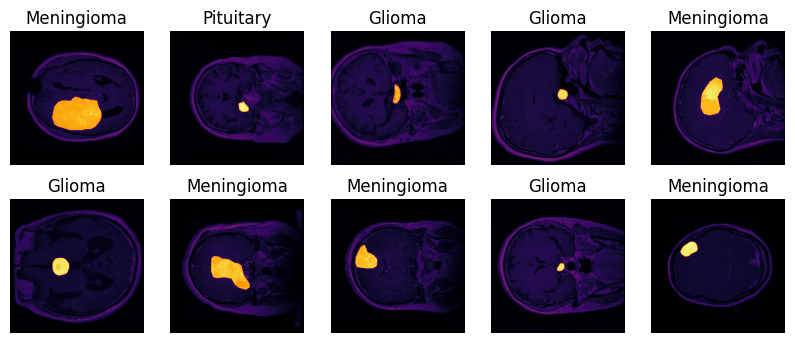

In [9]:
labels = ['Meningioma', 'Glioma', 'Pituitary']
plt.figure(figsize=(10, 4))
for i in range(10):
  index = random.randint(0, len(train_data)-1)
  image, label = train_data[index]
  image = (image*0.5 + 0.5).numpy()
  
  mask = 0.5*image[0,:,:] + image[1,:,:]

  plt.subplot(2, 5, i+1)
  plt.axis('off')
  plt.title(str(labels[label.item()-1]))
  plt.imshow(mask, cmap='inferno')

In [10]:
model = models.SimpleModelWithReLU()
optimizer = optim.Adam(model.parameters(), 0.01)

epochs = 10
simple_model_with_relu_dic = Trainer.train(
  train_dataloader, val_dataloader, model,
  optimizer, device, epochs,
  ModelCheckpoint(verbose=True)
)

Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:46<00:00,  2.35s/it]



Epoch (1/10): train_loss = 0.993945, val_loss= 0.005905, train_acc = 0.588300, val_acc= 0.673770

Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:23<00:00,  1.20s/it]



Epoch (2/10): train_loss = 0.502516, val_loss= 0.006130, train_acc = 0.787315, val_acc= 0.780328



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:24<00:00,  1.20s/it]



Epoch (3/10): train_loss = 0.356088, val_loss= 0.000214, train_acc = 0.872608, val_acc= 0.896721

val_loss changed (0.005905 -> 0.000214). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:24<00:00,  1.20s/it]



Epoch (4/10): train_loss = 0.263990, val_loss= 0.003101, train_acc = 0.908147, val_acc= 0.908197



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]



Epoch (5/10): train_loss = 0.170546, val_loss= 0.000129, train_acc = 0.942045, val_acc= 0.901639

val_loss changed (0.000214 -> 0.000129). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]



Epoch (6/10): train_loss = 0.179495, val_loss= 0.000479, train_acc = 0.939311, val_acc= 0.893443



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:23<00:00,  1.20s/it]



Epoch (7/10): train_loss = 0.136574, val_loss= 0.004059, train_acc = 0.953527, val_acc= 0.893443



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:24<00:00,  1.20s/it]



Epoch (8/10): train_loss = 0.209524, val_loss= 0.000312, train_acc = 0.927829, val_acc= 0.877049



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:24<00:00,  1.20s/it]



Epoch (9/10): train_loss = 0.132815, val_loss= 0.000316, train_acc = 0.952433, val_acc= 0.932787



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:22<00:00,  1.15s/it]


Epoch (10/10): train_loss = 0.096046, val_loss= 0.000304, train_acc = 0.964461, val_acc= 0.972131



In [11]:
model = models.SimpleModelWithSELU()
optimizer = optim.Adam(model.parameters(), 0.01)

epochs = 10
simple_model_with_selu_dic = Trainer.train(
  train_dataloader, val_dataloader, model,
  optimizer, device, epochs,
  ModelCheckpoint(verbose=True)
)

Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:23<00:00,  1.19s/it]



Epoch (1/10): train_loss = 0.979395, val_loss= 0.000399, train_acc = 0.691088, val_acc= 0.750820

Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:23<00:00,  1.19s/it]



Epoch (2/10): train_loss = 0.411543, val_loss= 0.000594, train_acc = 0.829415, val_acc= 0.822951



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:23<00:00,  1.19s/it]



Epoch (3/10): train_loss = 0.265959, val_loss= 0.003220, train_acc = 0.891744, val_acc= 0.877049



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:23<00:00,  1.18s/it]



Epoch (4/10): train_loss = 0.183547, val_loss= 0.005098, train_acc = 0.932203, val_acc= 0.878689



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:23<00:00,  1.19s/it]



Epoch (5/10): train_loss = 0.191817, val_loss= 0.001491, train_acc = 0.923455, val_acc= 0.911475



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:23<00:00,  1.18s/it]



Epoch (6/10): train_loss = 0.193073, val_loss= 0.002426, train_acc = 0.932203, val_acc= 0.934426



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:24<00:00,  1.20s/it]



Epoch (7/10): train_loss = 0.140914, val_loss= 0.001851, train_acc = 0.943138, val_acc= 0.950820



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:23<00:00,  1.18s/it]



Epoch (8/10): train_loss = 0.082907, val_loss= 0.000177, train_acc = 0.969382, val_acc= 0.793443

val_loss changed (0.000399 -> 0.000177). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]



Epoch (9/10): train_loss = 0.250018, val_loss= 0.000160, train_acc = 0.924549, val_acc= 0.891803

val_loss changed (0.000177 -> 0.000160). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:23<00:00,  1.17s/it]


Epoch (10/10): train_loss = 0.085984, val_loss= 0.000794, train_acc = 0.967742, val_acc= 0.949180



/tmp/ipykernel_1662/256893985.py:60: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


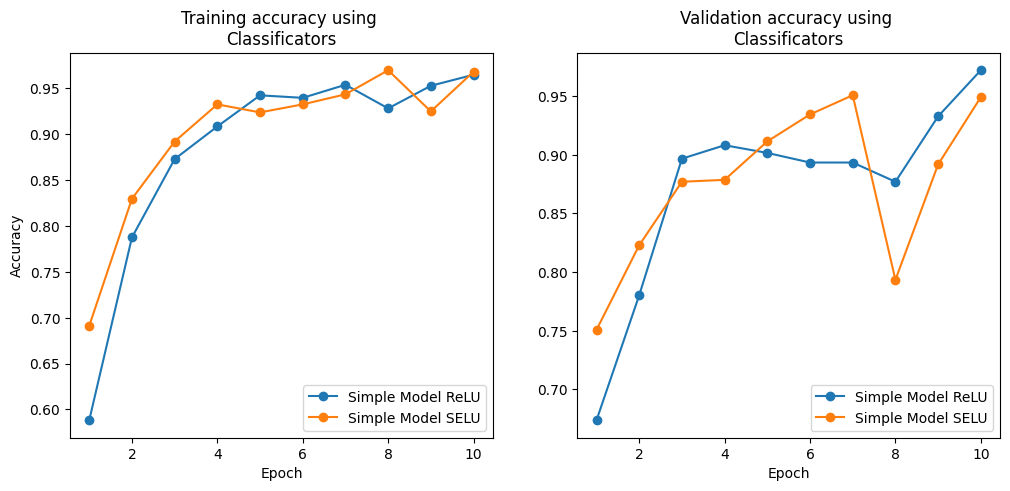

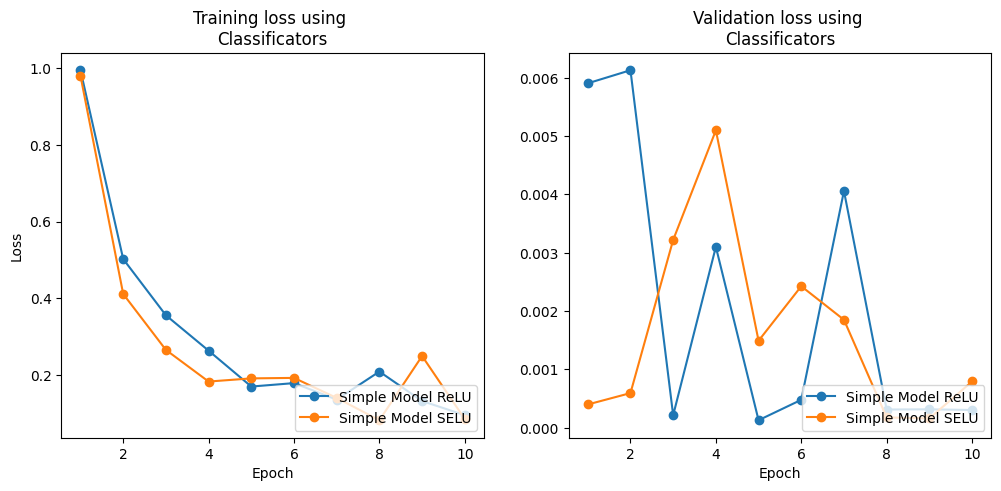

In [14]:
plot_metric_from_array(
  {
    'Simple Model ReLU': simple_model_with_relu_dic,
    'Simple Model SELU': simple_model_with_selu_dic
  },
  '\nClassificators'
)
plot_metric_from_array(
  {
    'Simple Model ReLU': simple_model_with_relu_dic,
    'Simple Model SELU': simple_model_with_selu_dic
  },
  '\nClassificators',
  metric='loss'
)